# Compact Programming Language Detectors
<hr>

## Approaches:
* ### Relying only on source code
    * Uses a neural networks (machine learning) based approach
    * Example package: Guesslang
    * Guesslang is used by Visual Studio Code for language detection
* ### Using source file information
    * Language detection leverages the presense of file extensions etc.
    * Example packages: Linguist, Polyglot
    * Linguist is used by Github for labelling language of a repository

## Detectors used for analysis:
* ### Guesslang
https://github.com/yoeo/guesslang
* ### Polyglot
https://github.com/pranavbaburaj/polyglot

## Basis of comparison
* ### Accuracy
Tested on test set of 80 source files
* ### Execution Time
Averaged run-time for the test files

In [ ]:
# install required packages
import sys
!{'"'+(sys.executable)+'"'} -m pip install numpy
!{'"'+(sys.executable)+'"'} -m pip install matplotlib
!{'"'+(sys.executable)+'"'} -m pip install guesslang
!{'"'+(sys.executable)+'"'} -m pip install python-polyglot

In [2]:
# import libraries
import os
import numpy as np
from polyglot.core import Polyglot
from guesslang import Guess
import matplotlib
import matplotlib.pyplot as plt
from time import process_time_ns

## Test dataset
* stored in directory **./data/**
* Contains source codes in 8 languages.
* Has 10 files for each language.
* Files are picked from open source repositories on github

In [3]:
# list of languages
langs = ["python", 'c', 'cpp', 'java', 'javascript', 'html', 'css', 'typescript']

# make directories for test dataset
for l in langs:
    for i in range(10):
        try:
            os.mkdir("./data/"+ l + str(i+1))
        except FileExistsError:
            continue

In [4]:
# Helper functions

def read_file(directory):
    """
    Function for reading code from source file
    """
    files = os.listdir(directory)
    if len(files) != 1:
        return ""
    file = files[0]
    f = open(directory + "/" + file, "r")
    source_code = f.read()
    f.close()
    return source_code

def update_conf_matrix(conf, actual, predicted):
    """
    Function for updating confusion matrix
    """
    predicted = predicted.lower()
    if predicted == "c++":
        predicted = "cpp"
    if predicted in langs:
        conf[langs.index(actual)][langs.index(predicted)] += 1
    else:
        conf[langs.index(actual)][len(langs)] += 1
        
def show_conf_matrix(matrix, name):
    """
    Funstion for displaying a confusion matrix
    """
    fig, ax = plt.subplots()
    img = ax.imshow(matrix)
    ax.set_xticks(np.arange(len(langs) + 1), labels = langs+["Other"])
    ax.set_yticks(np.arange(len(langs)), labels=langs)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(len(langs)):
        for j in range(len(langs) + 1):
            text = ax.text(j, i, int(matrix[i, j]), ha="center", va="center", color="w")
    ax.set_title("Confusion matrix - " + name)
    ax.set_xlabel("Predicted language")
    ax.set_ylabel("Actual language")
    fig.tight_layout()
    plt.show()

## Working of the language detectors

### Guesslang
* Neural network implemented using tensorflow.
* Performs forward propagation on trained model to predict language.

### Polyglot
* Looks up language for filename extension in a language detection file (languages.yaml)
* Creates objects for all files in a directory and computes percentage of each language in the directory.

In [5]:
# Initialize confusion matrices and arrays to store execution time
conf_guess = np.zeros((len(langs), len(langs)+1))
conf_pgt = np.zeros((len(langs), len(langs)+1))
time_guess = np.zeros((len(langs), 10))
time_pgt = np.zeros((len(langs), 10))

guess = Guess()

# make this variable True to see details:
see_details = False

for l in langs:
    for i in range(10):
        if see_details:
            print(l, i + 1)
        dirname = "./data/" + l + str(i+1)
        
        # use guseslang to detect language
        source_code = read_file(dirname)
        if source_code == "":
            lang_name = "None"
        else:
            start = process_time_ns()
            lang_name = guess.language_name(source_code)
            end = process_time_ns()
        if see_details:
            print("\tguesslang:", lang_name)
        time_guess[langs.index(l)][i] = end - start
        update_conf_matrix(conf_guess, l, lang_name)
        
        # use polyglot to detect language
        polyglot = Polyglot(dirname)
        start = process_time_ns()
        stats = polyglot.show(display=False) ['files']
        end = process_time_ns()
        try:
            lang_name = max(stats, key = lambda x: stats[x]['total'])
        except ValueError:
            lang_name = "None"
        if see_details:
            print("\tpolyglot :", lang_name, "\n")
        time_pgt[langs.index(l)][i] = end - start
        update_conf_matrix(conf_pgt, l, lang_name)

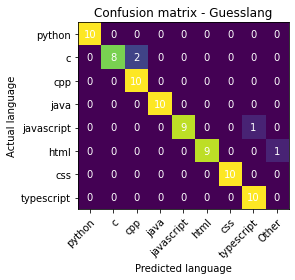

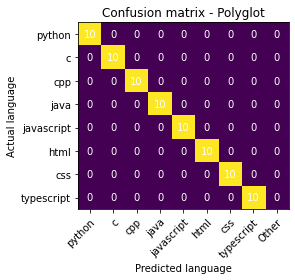


Average time taken by guesslang: 19.7265625 milli-seconds
Average time taken by polyglot : 1207.8125 milli-seconds


In [6]:
# visualize confusion matrices
show_conf_matrix(conf_guess, "Guesslang")
show_conf_matrix(conf_pgt, "Polyglot")

# see difference in execution times
print()
print("Average time taken by guesslang:", np.mean(time_guess) / (10**6), "milli-seconds")
print("Average time taken by polyglot :", np.mean(time_pgt) / (10**6), "milli-seconds")

## Results
* ### Accuracy
    * Guesslang confused 2/10 C programs to be C++, 1/10 HTML script to be Go, and 1/10 JavaScript code to be TypeScript.
    * This can be explained because C, C++ and JavaScript, TypeScript have similar syntax.
    * Polyglot predicted every language correctly as all files had correct extensions.

* ### Execution Time
    * On average, guesslang only took 19.73 ms for each prediction, whereas polyglot took 1207.81 ms.
    * This makes sense because guesslang only had to preprocess code and perform forward propagation, whereas polyglot computed percentages of each language by number of files and number of lines in the entire directory.

## Conclusion
* ### Guesslang is fast, however it gets confused between languages with similar syntax.
* ### Ployglot is slow, but is perfect if the file name extensions are known. It is useless if the files donot have apprppriate extensions.

## My suggested idea for solving this problem
* If file extension is available, use that to predict language by looking up a language file like polyglot.
* Otherwise, use the detector described as follows:
    * Learn feature set for languages through training set
    * Feature set should contain: 
        * Frequency of characters other than letters and digits (,.-_/#$% etc.)
        * List of commonly occuring keywords of the language
    * Compares test source code with feature library and returns the language which matches the most.